# Learning Notebook - SLU11 - Validation Metrics for Classification


By now you are already a fan of `scikit-learn`, or at least find it useful. You will then like to know that it also includes most of the **validation metrics for classification** you will ever use (which can mostly be found [here](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). 

The validation metrics for classification presented in this notebook are:
- Accuracy Score
- Confusion Matrix
- Precision
- Recall
- F1-Score
- Area Under the Receiver Operating Characteristic curve (AUROC)

----
* Originally by [Hugo Lopes](https://www.linkedin.com/in/hugodlopes/), adapted by [Pedro Fonseca](https://www.linkedin.com/in/pedrogfonseca/), slight modifications done by [Ricardo Alberto](https://www.linkedin.com/in/ricardoalberto93/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The sklearn metrics:
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score

from utils import threshold_df_at, paint, get_rates, plot_roc_curve, \
    get_data, make_confmat_pretty, get_realistic_dataset 

from utils import get_subset

%matplotlib inline 

# Setting up the problem

In order to calculate validation metrics, we first need to get some predictions. 

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Patient #</th>      <th>age</th>      <th>sex</th>      <th>cp</th>      <th>trestbps</th>      <th>chol</th>      <th>fbs</th>      <th>disease</th>      <th>predicted_proba</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>0</td>      <td>6.981588</td>      <td>2.143498</td>      <td>1.043253</td>      <td>8.252384</td>      <td>4.507519</td>      <td>2.812073</td>      <td>0.0</td>      <td>0.050365</td>    </tr>    <tr>      <th>1</th>      <td>1</td>      <td>7.424864</td>      <td>2.143498</td>      <td>4.173013</td>      <td>9.106078</td>      <td>5.532835</td>      <td>0.000000</td>      <td>1.0</td>      <td>0.969133</td>    </tr>    <tr>      <th>2</th>      <td>2</td>      <td>7.424864</td>      <td>2.143498</td>      <td>4.173013</td>      <td>6.829559</td>      <td>4.430137</td>      <td>0.000000</td>      <td>0.0</td>      <td>0.365029</td>    </tr>    <tr>      <th>3</th>      <td>3</td>      <td>4.100298</td>      <td>2.143498</td>      <td>3.129760</td>      <td>7.398689</td>      <td>4.836394</td>      <td>0.000000</td>      <td>0.0</td>      <td>0.032620</td>    </tr>    <tr>      <th>4</th>      <td>4</td>      <td>4.543573</td>      <td>0.000000</td>      <td>2.086507</td>      <td>7.398689</td>      <td>3.946497</td>      <td>0.000000</td>      <td>0.0</td>      <td>0.010980</td>    </tr>  </tbody></table>

This is a (highly simplified) version of a heart disease prediction dataset. 

The target is the `disease` column (the penultimate one), which is
> - 0 if the patient is healthy 
> - 1 if the patient has heart disease 

We also have some predicted probabilities of the patient being ill (the last column, `predicted_proba`). 

These predictions may have come from a classifier, from a heuristic, from a doctor, etc. It does not really matter for our purposes, we're just here to evaluate them! 

As such, we can reduce our dataset for this SLU to just... this: 

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>disease</th>      <th>predicted_proba</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>0.0</td>      <td>0.050365</td>    </tr>    <tr>      <th>1</th>      <td>1.0</td>      <td>0.969133</td>    </tr>    <tr>      <th>2</th>      <td>0.0</td>      <td>0.365029</td>    </tr>    <tr>      <th>3</th>      <td>0.0</td>      <td>0.032620</td>    </tr>    <tr>      <th>4</th>      <td>0.0</td>      <td>0.010980</td>    </tr>  </tbody></table>

In [2]:
data = pd.read_csv('data/heart_disease_binary.csv')[['disease', 'predicted_proba']]

# Evaluating predictions 

At this point, we have:
1. some probabilities which we predicted (`predicted_proba`)
2. some true outcomes (`disease`) 

#### Accuracy 

Let's start by asking the most obvious question. How is our accuracy? 

Calculating this is not as obvious, as we don't have 0 and 1 predictions. But we can say that anything we predicted over a threshold (let's say 0.5) is 1, and everything under that threshold is. 

In [3]:
data[['disease','predicted_proba']].head(5)

,disease,predicted_proba
0,0.0,0.050365
1,1.0,0.969133
2,0.0,0.365029
3,0.0,0.032620
4,0.0,0.010980


Let's make a quick function that does the following: 

> - if the probability is over or equal to a threshold, return 1 
> - if the probability is under the threshold, return 0 

In [4]:
def threshold_probas(proba, threshold=.5): 
    if proba >= threshold:
        return 1
    else: 
        return 0 

Great, now let's use this to create a prediction column: 

In [5]:
data['prediction'] = data.predicted_proba.map(threshold_probas)

Et voilá! 

In [6]:
data[['disease','predicted_proba', 'prediction']].head(5)

,disease,predicted_proba,prediction
0,0.0,0.050365,0
1,1.0,0.969133,1
2,0.0,0.365029,0
3,0.0,0.032620,0
4,0.0,0.010980,0


As we can see in the last 2 columns, the low probabilities became 0s, and the high ones became 1s. 

So, quite informally, what is the accuracy? 

$$ A = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions} $$

Let's get the "predictions we got right" column: 

In [7]:
data['correct prediction'] = data['prediction'] == data['disease']

Quick look at a sample of 5 predictions 

In [8]:
display(data['correct prediction'].sample(5, random_state=10))

246    False
183     True
229     True
126     True
184     True
Name: correct prediction, dtype: bool

Now, let's calculate accuracy: 

In [9]:
number_of_correct_predictions = data['correct prediction'].sum()
total_number_of_predictions = data.shape[0]

accuracy = number_of_correct_predictions / total_number_of_predictions
print(accuracy)

0.9372937293729373


Almost 94% accuracy! Not bad! Or... is it? 

----- 

# The problem with accuracy 

Let's say that we have a more realistic dataset, where only ~0.4% of the population has heart disease: 

In [10]:
realistic_data = get_realistic_dataset()

In [11]:
realistic_data.head(3)

,Patient #,age,sex,cp,trestbps,chol,fbs,disease,predicted_proba
202,202,6.316675,2.143498,3.129760,8.536948,2.437542,2.812073,0.0,0.023472
50,50,4.543573,0.000000,2.086507,5.975864,3.830424,0.000000,0.0,0.014811
301,301,6.316675,0.000000,2.086507,7.398689,4.565556,0.000000,0.0,0.010715


Let's check that really only ~0.4% of the population has heart disease: 

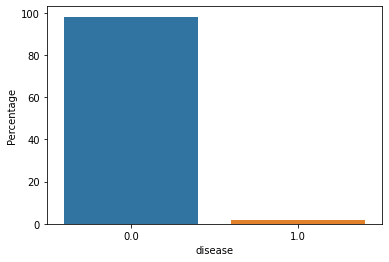

In [12]:
ax = sns.barplot(x = 'disease', y = 'disease', data=realistic_data, estimator=lambda x: len(x) / len(realistic_data) * 100)
ax.set(ylabel="Percentage")
plt.show()

Sounds about right, in the percentage chart we can barely see the percentage of the population that has heart disease!

So... if all we're being evaluated on is how often we get the answer right, doesn't it make sense to always predict 0? 

In [13]:
realistic_data['always zero'] = 0 

Take a minute of your time to understand the next line of code:

In [14]:
realistic_data['correct answer'] = realistic_data['always zero'] == realistic_data['disease']

In [15]:
number_of_correct_predictions = realistic_data['correct answer'].sum()
total_number_of_predictions = realistic_data.shape[0]

accuracy = number_of_correct_predictions / total_number_of_predictions
print(accuracy)

0.9820627802690582


Oh. So, by predicting always zero, we get an accuracy of over 98%. 

Conclusion: 
>> **Accuracy is as dangerous as it is intuitive, but only works on well balanced datasets**

Sidenote: There are ways to deal with unbalanced datasets, but we won't go into detail here, since it is not the scope of the SLU. Two common ways of dealing with this problem are [over-sampling](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and [under-sampling](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html). They solve the problem by rebalancing the classes, either by increasing the number of observations from the minority class of by decreasing the number of observations from the majority class.

----

# Step into the confusion matrix, Neo. 

The confusion matrix has a scary name but is actually a simple concept. 

<img src="data/Conf_mat_raw.png" width="500">

In binary classification, we either predicted 0 or 1, and we're either right, or wrong. 

This matrix covers all cases. 

<img src="data/confusion_mat_labelled.png" width="500">

- If we predicted positive, and it was positive, then it is a **True Positive**
- If we predicted negative, and it was negative, then it is a **True Negative**
- If we predicted positive, and it was negative, then it is a **False Positive**  
- If we predicted negative, and it was positive, then it is a **False Negative**

Deconstructing the logic: 
- The word "positive" or "negative" refers to what we predicted. 
- The word "true" or "false" refers to whether the prediction was correct. 

Capiche? Good. Because almost everything from here on depends on this. 

# Scikit confusion matrix 

Let's calculate the confusion matrix for our original dataset, with our predictions 

In [16]:
data[['disease','predicted_proba', 'prediction']].head(3)

,disease,predicted_proba,prediction
0,0.0,0.050365,0
1,1.0,0.969133,1
2,0.0,0.365029,0


In [17]:
# this is scikit-learn's confusion matrix, we will use it a lot! 
confmat = confusion_matrix(y_true=data['disease'], 
                           y_pred=data['prediction'])

In [18]:
confmat

array([[219,   0],
       [ 19,  65]])

Without wanting to include matplotlib code here, we've made a util to pretty this up: 

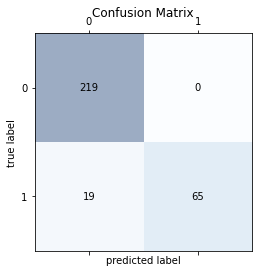

In [19]:
make_confmat_pretty(confmat)

So, we can look at this and notice a few things:


Reading horizontally, entire first row:
> _"Of the times the patient was healthy, we always predicted that he was healthy (hurray!)"_

Reading horizontally, entire second row:
> _"Of the times the patient was sick, we were wrong 19 times, which is a lot of mistakes when we consider that there were only 84 (19+65) sick patients"_ 

Reading vertically, entire first column: 
> _"Of the times when we predicted that the patient was healthy, they were healthy 219 times (out of a total of 238), but sick 19 times."_   
(_Note how this is different from the first row conclusion_)

Reading vertically, entire second column:
> _"Of the times we predicted sick, the patient was always sick."_ 

## Types of errors

You will admit that the confusion matrix gives us a much more nuanced idea that the accuracy being 93% could. 

One important thing to bear in mind is that different types of errors can weight differently. 

For instance, in our case, we have two options:  
>    A. Err on the side of making healthy patients take more tests  
>    B. Err on the side of sending sick patients away without help   

Clearly option B is more problematic. But when we look at our confusion matrix, that seems to be exactly what we are doing. When they were healthy, we always said they were healthy, but when they were sick, we very often said they were healthy _(can you see that in the confusion matrix?)_. 

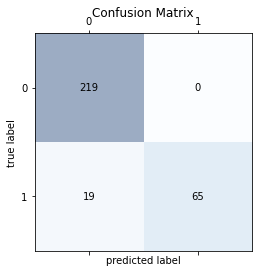

In [20]:
make_confmat_pretty(confmat)

#### Therefore, this model, with 93% accuracy... sucks for the purpose it was designed to achieve! 

There are two types of errors: 
>> Type 1: False Positive  
>> Type 2: False Negative  

But, to be honest, most of use just use this picture to remember it: 

![](https://4.bp.blogspot.com/-wmZzvsY_Tec/Vws0f4MJn9I/AAAAAAAAORs/gipKxA7aDboP0gx2vSmyQS_ZoVBPzqaWA/s1600/Type%2BI%2Band%2BII%2Berror.jpg)

# Classification Metrics

Alright, now to some metrics stuff (we'll do the Accuracy again with a bit more formality now) 

In [21]:
predicted = data['prediction']
observed = data['disease']

## Accuracy score
The [**accuracy**](http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) is the fraction of correct predictions. It is given by:  

$$ A = \frac{TP + TN}{TP + TN + FP + FN} $$

Where, $TP$ corresponds to the True Positives, $TN$ the True Negatives, $FP$ the False Positives, and $FN$ the False Negatives.

The main advantage of this metric is its simplicity and common understanding of what it means for everyone. Disadvantages of this metric:
- Not recommended its use in highly imbalanced datasets.
- You have to set a threshold for the output of the classifiers.

In [22]:
print('Accuracy = %2.3f' % accuracy_score(y_pred=predicted, y_true=observed))

Accuracy = 0.937


## Precision, Recall 

- [**Precision**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) is the ability of the classifier not to label as positive a sample that is negative (i.e., a measure of result relevancy).
$$ P = \frac{TP}{TP+FP} $$  

In the confusion matrix, precision would be the bottom right (65) divided by the sum of the second column (65)

In [23]:
precision_score(y_pred=predicted, y_true=observed)

1.0

- [**Recall**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) is the ability of the classifier to find all the positive samples (i.e., a measure of how many truly relevant results are returned).
$$ R = \frac{TP}{TP+FN} $$  


In the confusion matrix, it is the true positives (65) divided by the bottom row (False Negatives (19) + True Positives (65))

In [24]:
recall_score(y_pred=predicted, y_true=observed)

0.7738095238095238

So, we have a model that has very high precision, and comparatively low recall. This means it would rather miss a sick patient than annoy a healthy patient with tests. In a medical application, that seems like a bad idea. 

As you might imagine, the higher your precision, the lower your recall, and vice versa. For the same model, you can tune the precision/recall tradeoff by setting different thresholds. 

#### One way to think about precision and recall is as follows: 

<img src="https://i.imgflip.com/2ombqy.jpg" width="300">

<img src="https://i.imgflip.com/2ombhi.jpg" width="300">

----- 

# F1 score 

F1 score is an attempt to find a "midground" between precision and recall. However, it should be used with caution, as it assumes that both False Positives and False Negatives have the same impact on the end objective, which in a real scenario is rarely true!

- [**F1 score**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) can be interpreted as a weighted harmonic mean of the precision and recall (in this case recall and precision are equally important).
$$ F1 = 2\frac{P \times R}{P+R} $$

In [25]:
print('F1 score = %1.3f' % f1_score(y_pred=predicted, y_true=observed))

F1 score = 0.872


In fact, I don't believe that I've ever found a situation where False Positives and False Negatives have the same impact, so feel free to reach out to me on Slack if you remember one!

It is safe to say that, in general, choosing F1 score as a metric is a bad idea. 

For further information on precision, recall and f1-score click [here](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures).

Always remember: _different metrics serve different purposes_. One of the most important issues is related with the balance of our binary classification problem. So, before computing any of the above metrics, you should check if the dataset has **class imbalance** (one of the classes, either 0 or 1, is present in the dataset in a much higher percentage than the other one).

As a final note on F1 score, some of you may be thinking: if this is not that useful in real-life, why are we learning it? To be frank you're learning this so that if you ever come across a site like [this](https://sebastianraschka.com/faq/docs/computing-the-f1-score.html) and read things like this: "What we are trying to achieve with the F1-score metric is to find an equal balance between precision and recall, which is extremely useful in most scenarios when we are working with imbalanced datasets (i.e., a dataset with a non-uniform distribution of class labels)." you don't believe it.

------

# Intuitions behind the ROC Curve 

Ok, now things are about to get funky. We are about to introduce one of the concepts you will use more often as a data scientist. Buckle up. 

Let's say we are trying to figure out how well our model does, by seeing how well it "ranks" the observations. 

We'll take it slowly. 

In [26]:
# ignore this if you want, just creating a subset to avoid showing 
# the full dataset all the time 
df = get_subset(data)
display(df.sample(5, random_state=104))

,predicted_proba,disease
104,0.977353,0.0
9,0.210351,0.0
161,0.050172,1.0
250,0.060706,0.0
244,0.041574,0.0


We established before that to make predictions we need to make a threshold, right? 

What we did before was set a threshold at 0.5:

In [27]:
df = threshold_df_at(df, .5)    # 50% threshold 
df.sample(5, random_state=3).style.apply(paint, axis=1)

,predicted_proba,disease,threshold at 0.5
245,0.872704,1.000000,1
162,0.016896,0.000000,0
10,0.018994,0.000000,0
161,0.050172,1.000000,0
73,0.057306,0.000000,0


Ok, not bad, but we got a False Negative on that red row here (it was positive, and we called it negative).  

What if we lower the threshold? Let's say to 0.05, to catch that red!  

In [28]:
df = threshold_df_at(df, .05)  # 5% threshold
df.sample(5, random_state=3).style.apply(paint, axis=1)

,predicted_proba,disease,threshold at 0.5,threshold at 0.05
245,0.872704,1.000000,1,1
162,0.016896,0.000000,0,0
10,0.018994,0.000000,0,0
161,0.050172,1.000000,0,1
73,0.057306,0.000000,0,1


Well, now we caught that one, but now classified a person who was healthy as sick. 

With 0.05, we have fewer **False Negatives**, but now we have more **False Positives**! 

The important conclusion here is as follows: 

> **It's hard to catch more True Positives without catching some False Positives**. 

To represent this "ability to catch True Positives" we will use the True Positive Rate, or 

> _"what fraction of the 1s have I called 1?"_. 

##### True Positive Rate 

$$TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$$ 


<img src="data/conf_mat_labelled_4.png" width="500">

To represent the False Positives (accidental catches), we will use the False Positive Rate, or 
> _"Of the observations that were 0, what fraction did I (wrongly!) call 1?"_

False Positive Rate 

$$FPR = \frac{FP}{N} = \frac{FP}{FP + TN} $$

<img src="data/confusion_mat_labelled 2.png" width="500">

Great, so we can now get a bunch of different thresholds, and see how we do at each: 

In [29]:
bunch_of_different_thresholds = np.round(np.linspace(0, 1, 21), 2)
bunch_of_different_thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [30]:
df = get_subset(data)  # just resetting the dataset 

for threshold in bunch_of_different_thresholds:
    df = threshold_df_at(df, threshold)

In [31]:
df.sample(10, random_state=10).style.apply(paint, axis=1)

,predicted_proba,disease,threshold at 0.0,threshold at 0.05,threshold at 0.1,threshold at 0.15,threshold at 0.2,threshold at 0.25,threshold at 0.3,threshold at 0.35,threshold at 0.4,threshold at 0.45,threshold at 0.5,threshold at 0.55,threshold at 0.6,threshold at 0.65,threshold at 0.7,threshold at 0.75,threshold at 0.8,threshold at 0.85,threshold at 0.9,threshold at 0.95,threshold at 1.0
246,0.029229,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
183,0.029229,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
229,0.779552,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
126,0.988070,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
184,0.007115,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.969133,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
59,0.075526,0.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
194,0.019427,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
132,0.007561,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,0.185493,0.000000,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So, at low thresholds, we have lots of red 1s (False Positives), and a high thresholds we have lots of red 0s (False Negatives). 

What is our TPR (True Positive Rate) and FPR (False Positive Rate) for each of these thresholds? 

In [32]:
rates = get_rates(df)
print('Showing some low thresholds...')
display(rates.head(4))

Showing some low thresholds...


,False Positive Rate,True Positive Rate
Threshold,,
0.003500,1.000000,1.000000
0.003924,0.995556,1.000000
0.003963,0.991111,0.987179
0.005204,0.937778,0.987179


This makes sense, at a really low threshold we are calling everything 1, so we're catching all the True Positives, but also all the False Positives.

In [33]:
print('Showing some high thresholds...')
display(rates.tail(4))

Showing some high thresholds...


,False Positive Rate,True Positive Rate
Threshold,,
0.979386,0.0,0.102564
0.988070,0.0,0.051282
0.990402,0.0,0.025641
0.992901,0.0,0.012821


This also makes sense, at really high thresholds we're calling everything 0, and therefore catch hardly any positives. 

Or, graphically...

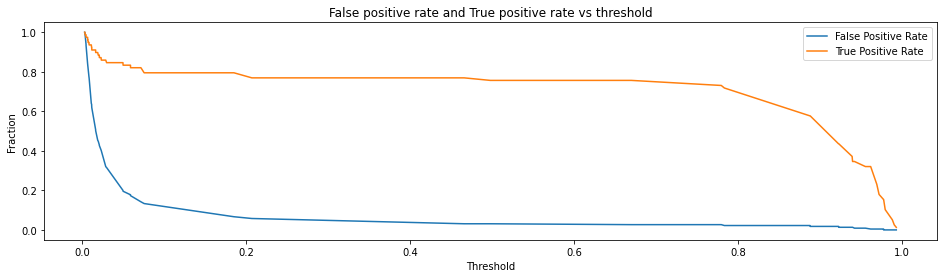

In [34]:
rates.plot(figsize=(16, 4))
plt.title('False positive rate and True positive rate vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Fraction')
plt.show()

Cool... so at really low thresholds ("always saying 1") we catch all the true positives, but immediately generate a tonne of false positives. 

Now (ok, last step I promise) this threshold axis is kind of redundant. We can just plot TPR vs FPR. 

In [35]:
rates = get_rates(df)

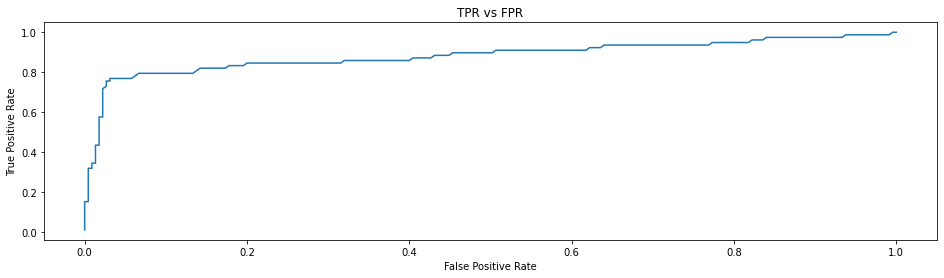

In [36]:
rates.set_index('False Positive Rate')['True Positive Rate'].plot(figsize=(16, 4))
plt.title('TPR vs FPR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Here we can observe a few interesting things. As you may remember, we were excellent at detecting a bunch of True positives before we start detecting any False positives (very high precision, like a judge). 

That is reflected in the fact that the curve grows very fast on the left side. Does that make sense? 

Here's the good news: we've just drawn a complete ROC Curve! 

----

# The ROC Curve 



The Receiver Operating Characteristic (ROC) curve is a very common (and important) metric for **binary classification problems** (when predicting 0 or 1). 

**Formally**, it is created by plotting the fraction of true positives out of the positives (TPR = true positive rate, a.k.a., sensitivity) vs. the fraction of false positives out of the negatives (FPR = false positive rate, or 1-specificity), at various threshold settings. Sklearn already provide us with all the tools:

Take a look at an example ROC curve below ([source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)):
!['ROC'](http://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png)

The desired curve is one that gets to top left corner the fastest possible (which as you can imagine maximizes the area below it). So, an ideal (but very suspicious) AUROC curve is 1.0, while in a completely random scenario we have an AUROC = 0.5. 

In the following images we've drawn a perfect and random classifier overlaid with the original (ok-ish) one. 

<img src="data/rocs.png" width="900">

Unlike the previous metrics, the ROC functions above require the actual scores/probabilities (and not the predicted labels, which would be 0 and 1). This has the major advantage of allowing you to compare two potential classifiers without having to choose a threshold in advance! 


Regarding the scikit tools to do this, we have one for creating the curve (generates the points to make the image), and another for calculating AUROC. 

- The [**`roc_curve`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) compute Receiver Operating Characteristic (ROC) curve points.
- The [**`roc_auc_score`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) function computes the Area Under the ROC curve (AUROC). I.e., the curve information is summarized in one number.  

In practice, you may often just use the roc_auc_score (AUROC) when comparing classifiers, but it's generally good practice to look at the full ROC curve before making a final decision. 

Let's calculate then the AU ROC (area under roc) of our heart disease classifier:

In [37]:
# The Area Under the ROC curve:
roc_auc = roc_auc_score(y_score=df['predicted_proba'], y_true=df['disease'])
print('The AU ROC of our classifier is = %.3f' % roc_auc)

The AU ROC of our classifier is = 0.882


Let's take a look at the ROC curve.

This is how you get the FRP, TPR and threshold using scikit: 

In [38]:
# Data to compute the ROC curve (FPR and TPR):
fpr, tpr, thresholds = roc_curve(y_score=df.predicted_proba, y_true=df.disease)

To make it pretty, this is some matplotlib code that you can keep re-using: 

In [39]:
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Note: this is ALL just matplotlib stuff, nothing scientific about it! 
    
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Finally, we will plot our ROC Curve (and put the AUROC in the label):

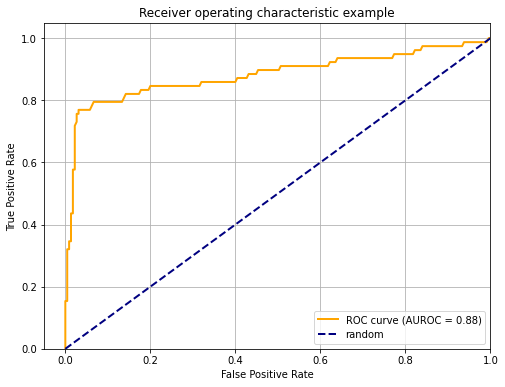

In [40]:
plot_roc_curve(roc_auc, fpr, tpr)

As we can see, the AUROC is around 0.9. 

# Choosing the best model

By now we're approaching the end of the SLU and I'm guessing that at least some of you are thinking that the best model for binary classification problems is always the one with the higher AUROC. While that is true if you're deploying a model in [Kaggle](https://www.kaggle.com/), in the real world, things are a little bit more complicated than that.

Imagine that you're working on a loan approval model (meaning that the output of your model determines if someone applying for a loan actually gets one). The model with the higher AUROC is likely to be one that also minimizes the chances of ethnical minories getting approved (this happens because the data is inherently biased - you'll learn more about this in SLU17 - Ethics and Fairness).

In this case, rather than optimizing for the best AUROC, a responsable data scientist should instead provide good tradeoffs, like a model that has slightly less AUROC but doesn't discriminate ethnical minorities. 

# Closing remarks 

A few notes before we go to the exercises: 
- A model being good or not always depends on the application 
- Sometimes even experienced data scientists make the mistake of trusting a single number
- ROC Curve measures the ability to rank, and does not depend on the threshold 
- Accuracy is dangerous because it assumes the dataset is balanced 
- Precision is more important when the cost of a False Positive is higher (e.g. law) 
- Recall is more important when the cost of a False Negative is higher (e.g. medicine) 
- F1 combines both precision and recall into a single metric, but assumes they are equally important, which rarely happens in practice. 